#### Импорт необходимых библиотек

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# устанавливаю общие настройки графиков
sns.set(rc={'figure.figsize': (15, 7)},
        font_scale=2)

#### Объявим функцию А/А теста

In [15]:
def AA_test(first_group, # первая группа
            second_group, # вторая группа
            simulations=1000, # кол-во симуляций
            n_size=1000): # размер выборок  

    res = [] # в этот список будут сохраняться p-values выборок

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = first_group.sample(n_size, replace = False).values
        s2 = second_group.sample(n_size, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    # выводим частоту ложных покрасов (должна быть меньше уровня значимости)
    print(f'FPR = {sum(np.array(res) <0.05) / simulations}') 

#### Считывание данных

In [16]:
df = pd.read_csv('hw_aa.csv', sep=';',index_col=0, decimal=',')
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [17]:
df.shape

(127018, 4)

In [18]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

Проверяем наличие пропущенныx значений

In [19]:
df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

Проверяем наличие дублированных значений

In [20]:
df.duplicated().sum()

0

#### Проводим А/А тест

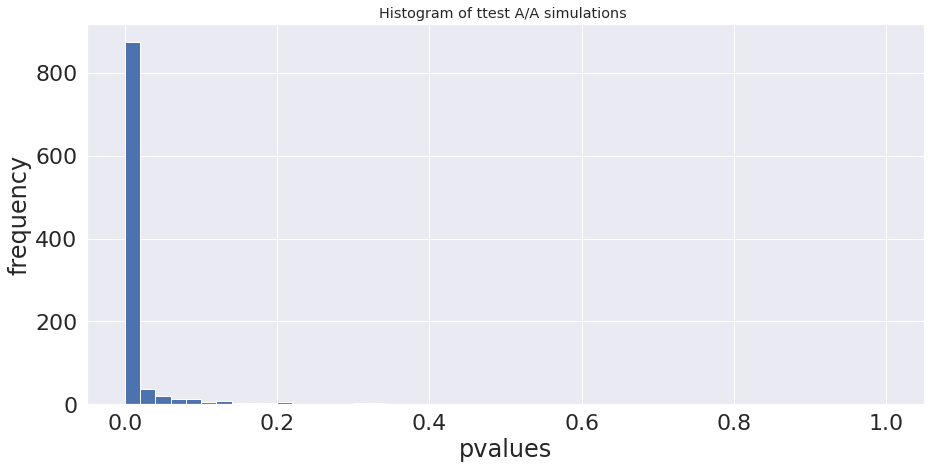

FPR = 0.926


In [21]:
AA_test(df.query('experimentVariant == 1').purchase, 
        df.query('experimentVariant == 0').purchase)

#### Заметим, что FPR значительно выше 0.05 и распределение скошено влево. Это говорит о том, что есть проблемы в работе сплит-системы, так как мы ожидаем FPR ниже уровня значимости альфа. 
FPR показывает , как часто в нашей системе сплитования мы отклоняем нулевую гипотезу при том, что она верна (частота ложных прокрасов).

#### Попробуем найти причины этого.

In [22]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

Рассчитаем коэффициент покупок в зависимости от варианта и версии мобильного приложения

In [24]:
purch_conversion = df \
                        .groupby(['experimentVariant', 'version'], as_index=False) \
                        .agg({'purchase': 'sum'})
purch_conversion

,experimentVariant,version,purchase
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895
5,1,v2.9.0,858
6,1,v3.7.4.0,266
7,1,v3.8.0.0,384


Сразу же бросается на глаза различие между конверсией в 0 и 1 варианте версии v2.8.0

In [12]:
purch_conversion.query("version == 'v2.8.0'")

,experimentVariant,version,purchase
0,0,v2.8.0,41
4,1,v2.8.0,1895


#### Проведем повторный А/А тест, но теперь по версии v2.8.0 мобильного приложения

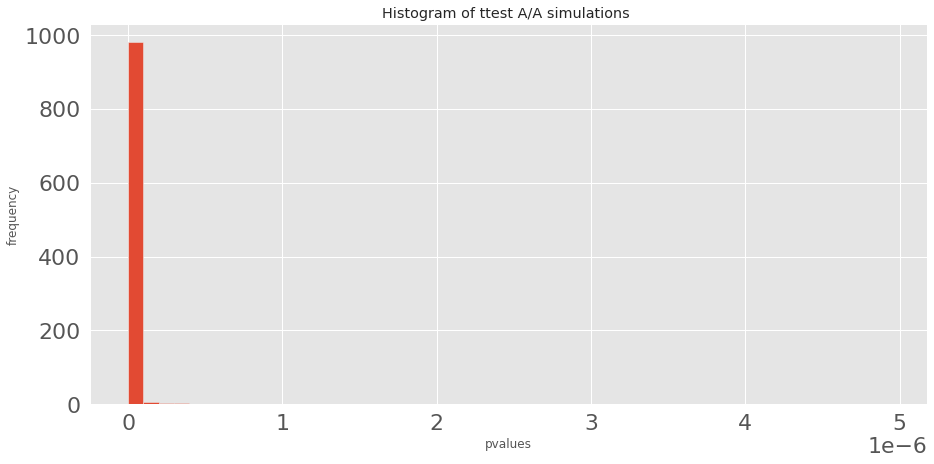

FPR = 1.0


In [26]:
# сначала проведем тест только по проблемной версии
AA_test(df.query("experimentVariant == 1 and version == 'v2.8.0'").purchase, 
        df.query("experimentVariant == 0 and version == 'v2.8.0'").purchase)

#### Мы нашли, в чем была проблема.

#### Для того чтобы окончательно в этом убедиться проведем тест со всеми версиями мобильного приложения без "проблемной".

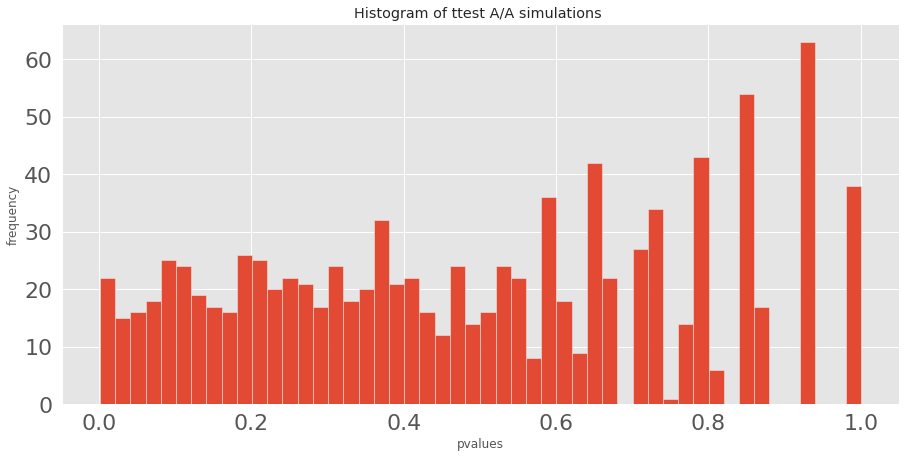

FPR = 0.045


In [27]:
AA_test(df.query("experimentVariant == 1 and version != 'v2.8.0'").purchase, 
        df.query("experimentVariant == 0 and version != 'v2.8.0'").purchase)

#### Вывод:
Проблема в данных мобильного приложения версии v2.8.0.

Согласно данным, есть проблема со сплит-системой в этой версии мобильного приложения.